# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [1]:
import sys
sys.path.append('../')

import data
from utils import show_sample
from enum import Enum
from model import DynamicUnet
from custom_transforms import RandomCutOut, ToGrayScale
import numpy as np

# import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Computer SPECS
gpu_id = 1
num_cores = 4
torch.cuda.set_device(gpu_id)

## DATA

In [3]:
# hyper parameters
bs = 8  # batch size
size = 512  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [4]:
class EMDataSet(Dataset):

    def __init__(self, data_pth, transforms=None):
        self.img_filepaths = list(data_pth.glob('*.tif'))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_filepaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_filepaths[idx]
        y = Image.open(img_name)
        if self.transforms:
            x = self.transforms['x'](y)
            y = self.transforms['y'](y)
        else:
            x = y
            print('WARNING: no transforms applied to target images, are you sure about that bud?')
        return x, y

In [5]:
config = {'min_n_holes': 10, 'max_n_holes': 15, 
          'min_size': 5, 'max_size': 10}
def get_inpainting_transforms(size=(256,256), config=None):
    tfms = {}
    tfms['x'] = transforms.Compose([ToGrayScale(3), 
                                    transforms.CenterCrop(size),
                                    RandomCutOut(config['min_n_holes'], config['max_n_holes'], 
                                                 config['min_size'], config['max_size']),
                                    transforms.ToTensor()])
    tfms['y'] = transforms.Compose([ToGrayScale(), 
                                    transforms.CenterCrop(size),
                                    transforms.ToTensor()])
    return tfms

size = 512
tfms = get_inpainting_transforms(size, config=config)
print(tfms)

{'x': Compose(
    ToGrayScale(3)
    CenterCrop(size=(512, 512))
    RandomCutOut(10, 15, 5, 5)
    ToTensor()
), 'y': Compose(
    ToGrayScale(1)
    CenterCrop(size=(512, 512))
    ToTensor()
)}


## TESTS

In [6]:
inpaint_dataset = EMSelfPlay(data_pth, transforms=tfms)

In [7]:
inpaint_dataloader = DataLoader(inpaint_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [8]:
# %debug
x, y = inpaint_dataset[2]

In [9]:
x.shape

torch.Size([3, 512, 512])

In [10]:
y.shape

torch.Size([1, 512, 512])

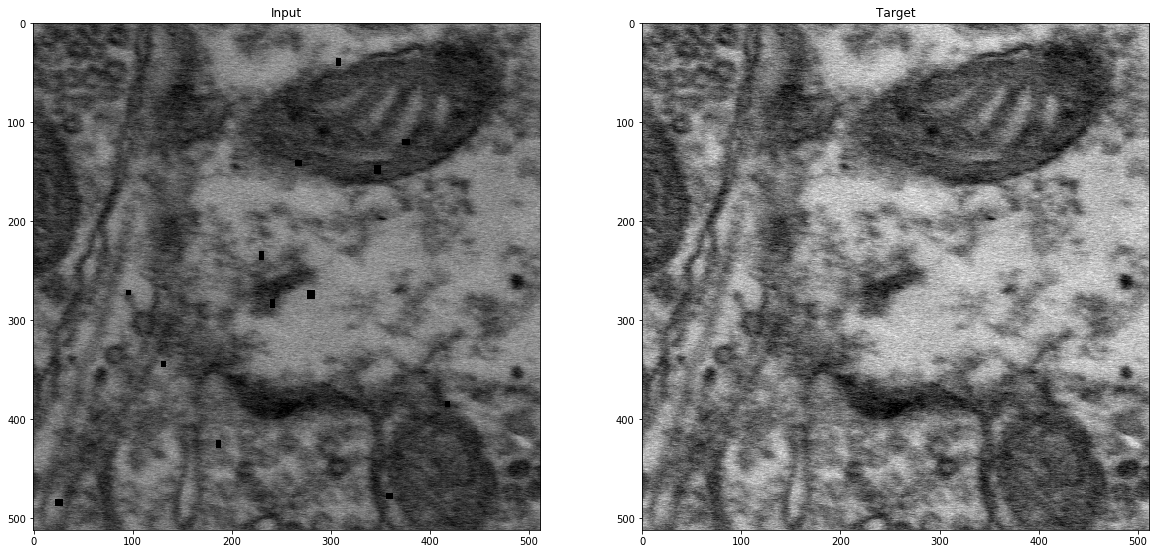

In [11]:
show_sample(inpaint_dataset)

## MODEL

In [12]:
arch = models.resnet34(True)
encoder = nn.Sequential(*list(arch.children())[:-2])
type(encoder)

torch.nn.modules.container.Sequential

In [13]:
nt = Enum('NormType', 'Batch BatchZero Weight Spectral')

In [14]:
model = DynamicUnet(encoder, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

In [15]:
model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

## TRAINING

In [16]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# %debug
num_epochs = 1
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    for j, sample_batch in enumerate(inpaint_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = sample_batch
        inputs = inputs.cuda()
        targets = targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(inputs)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j % (print_every) == 0:
            print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
            running_loss = 0.0

Epoch 1 Batch 1 loss: 0.00018700847867876292
Epoch 1 Batch 11 loss: 0.0018556938506662846
Epoch 1 Batch 21 loss: 0.00184641886735335
Epoch 1 Batch 31 loss: 0.0017504032235592603
Epoch 1 Batch 41 loss: 0.0018147548311389984
Epoch 1 Batch 51 loss: 0.0019050989882089197
Epoch 1 Batch 61 loss: 0.001740511425305158
Epoch 1 Batch 71 loss: 0.0018063590512610971
Epoch 1 Batch 81 loss: 0.0016531244618818164
Epoch 1 Batch 91 loss: 0.0016243672114796936
Epoch 1 Batch 101 loss: 0.0016147793154232203
Epoch 1 Batch 111 loss: 0.00162001121789217
Epoch 1 Batch 121 loss: 0.0016878994298167526
Epoch 1 Batch 131 loss: 0.0015913084498606622
Epoch 1 Batch 141 loss: 0.0015643318882212042
Epoch 1 Batch 151 loss: 0.0015733840293250978
Epoch 1 Batch 161 loss: 0.0015758625813759863
Epoch 1 Batch 171 loss: 0.0016126309288665651
Epoch 1 Batch 181 loss: 0.0015287760994397103
Epoch 1 Batch 191 loss: 0.0015911803930066526
Epoch 1 Batch 201 loss: 0.0015000380109995604
Epoch 1 Batch 211 loss: 0.0015389189939014614
Epo

KeyboardInterrupt: 

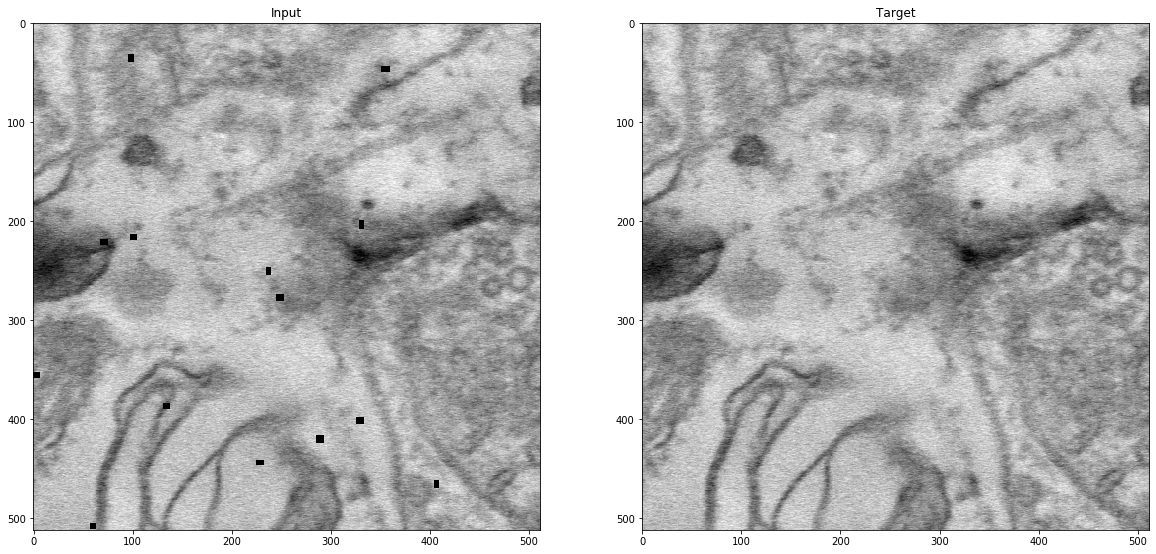

In [27]:
show_sample(inpaint_dataset, idx=32000)

In [28]:
x, y = inpaint_dataset[32000]

In [36]:
model.eval();
pred = model(x.unsqueeze(0).cuda())

In [52]:
pred.permute(3,2,0,1).squeeze()

tensor([[0.4476, 0.5348, 0.5297,  ..., 0.5380, 0.5561, 0.3788],
        [0.5137, 0.6137, 0.5727,  ..., 0.5611, 0.6021, 0.5166],
        [0.7518, 1.0160, 0.7877,  ..., 0.5731, 0.5893, 0.6153],
        ...,
        [0.6684, 0.9183, 0.7371,  ..., 0.4335, 0.3497, 0.3440],
        [0.5774, 0.8920, 0.6092,  ..., 0.4359, 0.4312, 0.3508],
        [0.4017, 0.6966, 0.5627,  ..., 0.4107, 0.4181, 0.2655]],
       device='cuda:1', grad_fn=<SqueezeBackward0>)

In [46]:
y.shape

torch.Size([1, 512, 512])

In [53]:
def show_result(x, y, pred, figsize=(20,20)):
    """A helper function to visualize data samples."""
    f, axarr = plt.subplots(1,3, figsize=figsize)  # create visualizations
    axarr[0].imshow(x.permute(1,2,0)) # visualize image tensor
    axarr[0].set_title('Input')
    axarr[1].imshow(y.permute(1,2,0).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[1].set_title('Target')
    axarr[2].imshow(pred.permute(3,2,0,1).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[2].set_title('Prediction')

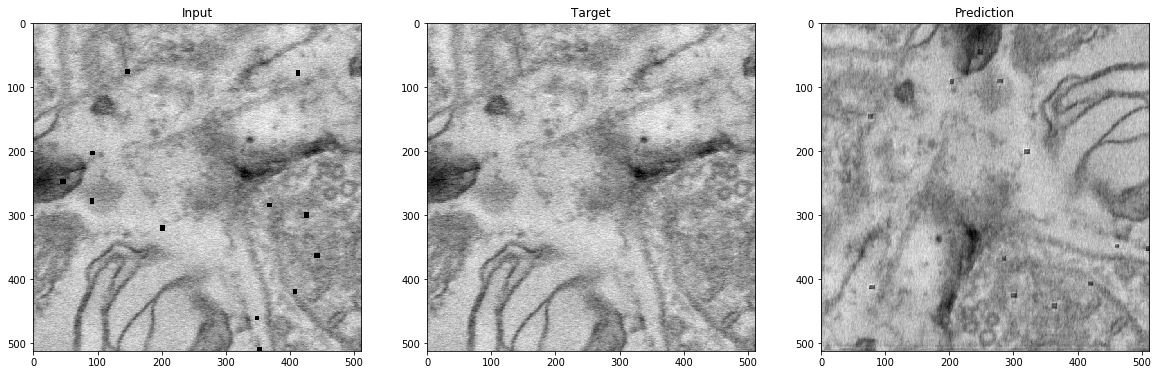

In [54]:
show_result(x, y, pred)